In [ ]:
# prompt: drive mout

from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:

import os
os.chdir('/content/drive/MyDrive/pneumonia_detection_epics')  # Change this path to your dataset folder

In [ ]:
import os, shutil
import random
import numpy as np
import pandas as pd
import cv2
import skimage
import matplotlib.pyplot as plt
import skimage.segmentation
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 224

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error loading image {img}: {e}")
    return np.array(data, dtype=object)


In [ ]:
train = get_data("chest_xray/chest_xray/train")
test = get_data("chest_xray/chest_xray/test")
val = get_data("chest_xray/chest_xray/val")

In [ ]:
pneumonia = os.listdir("chest_xray/chest_xray/train/PNEUMONIA")
penomina_dir = "chest_xray/chest_xray/train/PNEUMONIA"

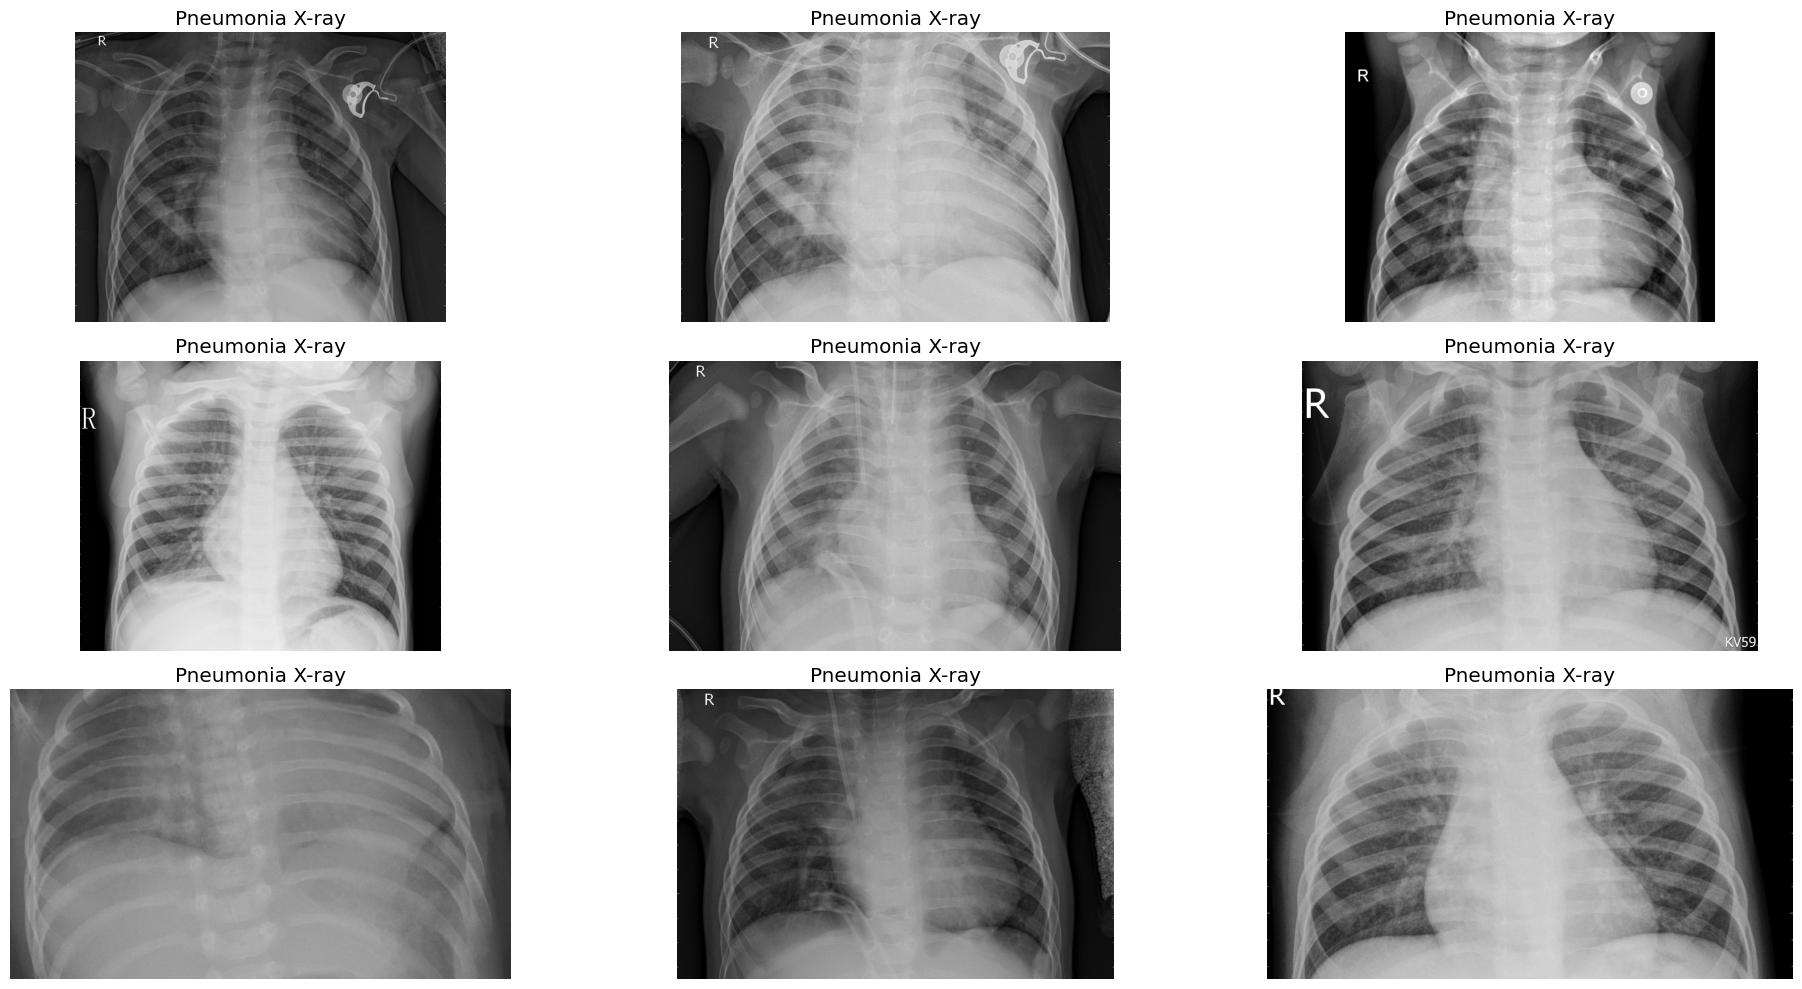

In [ ]:
plt.figure(figsize=(20,10))

for i in range(9):
    plt.subplot(3,3, i+1)
    img = plt.imread(os.path.join(penomina_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Pneumonia X-ray")
plt.tight_layout()

In [ ]:
normal = os.listdir("chest_xray/chest_xray/train/NORMAL")
normal_dir = "chest_xray/chest_xray/train/NORMAL"

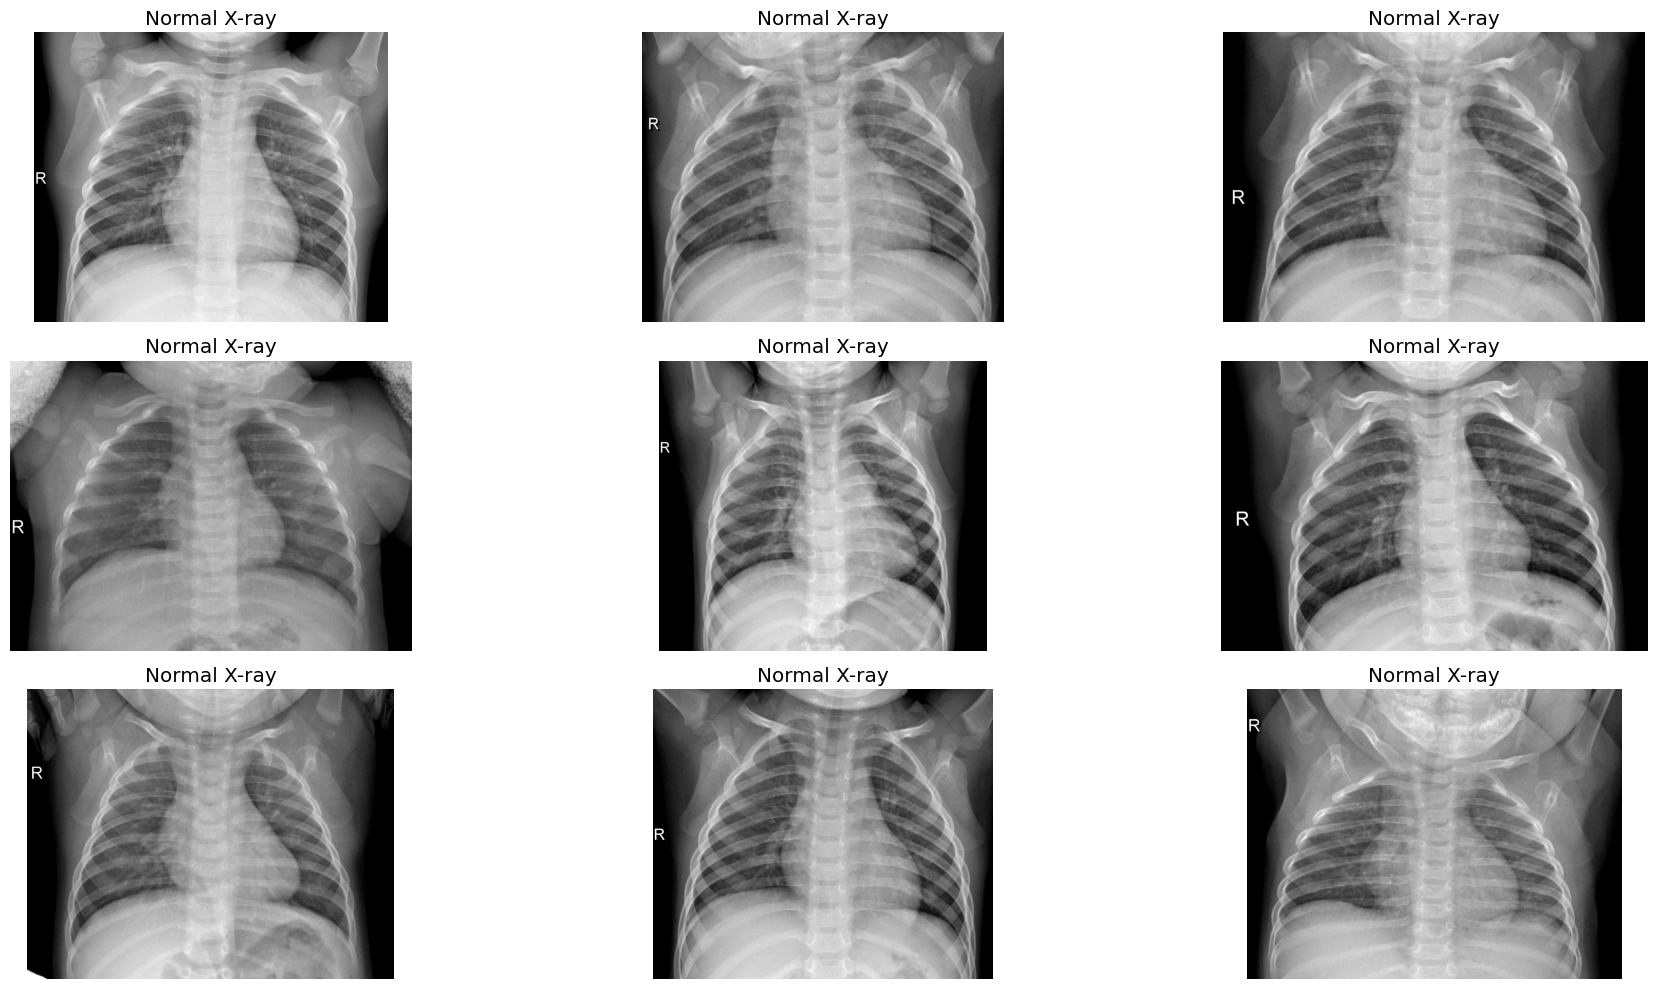

In [ ]:
plt.figure(figsize=(20,10))

for i in range(9):
    plt.subplot(3,3, i+1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Normal X-ray")
plt.tight_layout()

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D,Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1. / 255,
                  horizontal_flip=0.4,
                  vertical_flip=0.4,
                  rotation_range=40,
                  shear_range=0.2,
                  width_shift_range=0.4,
                  height_shift_range=0.4,
                  fill_mode="nearest")
valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory("chest_xray/chest_xray/train",
                                 batch_size = 32,
                                 target_size=(224,224),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')
valid_generator = valid_datagen.flow_from_directory("chest_xray/chest_xray/val",
                                 batch_size = 32,
                                 target_size=(224,224),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory("chest_xray/chest_xray/test",
                                 batch_size = 32,
                                 target_size=(224,224),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')

Found 624 images belonging to 2 classes.


In [ ]:

class_labels = train_generator.class_indices

In [ ]:
class_labels

{'NORMAL': 0, 'PNEUMONIA': 1}

In [ ]:

class_name = {value:key for (key, value) in class_labels.items()}

In [ ]:
class_name

{0: 'NORMAL', 1: 'PNEUMONIA'}

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, Dropout, GlobalAveragePooling2D, Multiply
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Multiply, Reshape
from tensorflow.keras.layers import BatchNormalization



In [ ]:
# 1. vgg19 model : adam as an optimizer(model_1 out of 4 models in Ensemble Model)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
# Define the base model with VGG19
base_model = VGG19(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

In [ ]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
vgg_features = x

x = Dense(4608, activation='relu')(x)
x = BatchNormalization()(x)  # Adding Batch Normalization
x = Dropout(0.5)(x)  # Dropout to reduce overfitting

x = Dense(1152, activation='relu')(x)
x = BatchNormalization()(x)  # Adding Batch Normalization
x = Dropout(0.5)(x)  # Dropout to reduce overfitting

output = Dense(2, activation='softmax')(x)


In [ ]:
model_04 = Model(inputs=base_model.inputs, outputs=output)

# Compile the model using the Adam optimizer with a learning rate scheduler
initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
adam = Adam(learning_rate=0.0001)

In [ ]:
model_04.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Print the model summary
print(model_04.summary())

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 140,969,410 (537.76 MB)

 Trainable params: 120,933,506 (461.32 MB)

 Non-trainable params: 20,035,904 (76.43 MB)

None


In [ ]:
# Define callbacks
es = EarlyStopping(monitor="val_loss", verbose=1, mode="min", patience=10, restore_best_weights=True)
cp = ModelCheckpoint("model_weights/vgg19_model_04.keras", monitor="val_loss", save_best_only=True, mode="min")
lrr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1, min_lr=1e-6)

In [ ]:
#print(len(train_generator))
#print(steps_per_epoch)

In [ ]:
# Train the model
#len(train_generator) = 163
history_04 = model_04.fit(
    train_generator,
    epochs=20,  # Train for more epochs
    validation_data=valid_generator,
    callbacks=[es, cp, lrr]
)

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 0.7152 - loss: 1.0216 - val_accuracy: 0.5000 - val_loss: 2.4228 - learning_rate: 1.0000e-04
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.8193 - loss: 0.5631 - val_accuracy: 0.6875 - val_loss: 1.4634 - learning_rate: 1.0000e-04
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 150s 873ms/step - accuracy: 0.8319 - loss: 0.4827 - val_accuracy: 0.6250 - val_loss: 1.7722 - learning_rate: 1.0000e-04
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.8530 - loss: 0.4001 - val_accuracy: 0.9375 - val_loss: 0.2512 - learning_rate: 1.0000e-04
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 156s 860ms/step - accuracy: 0.8846 - loss: 0.3483 - val_accuracy: 0.7500 - val_loss: 0.6431 - learning_rate: 1.0000e-04
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 185s 800ms/step - accuracy: 0.8701 - loss: 0.3924 - val_accuracy: 0.8750 - val_loss: 0.3070 - learning_rate: 1.0000e-04
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 139s 774m

In [ ]:
# Evaluate the model on validation and test sets
vgg_val_eval_04 = model_04.evaluate(valid_generator)
vgg_test_eval_04 = model_04.evaluate(test_generator)

# Print the results
print(f"Validation Loss: {vgg_val_eval_04[0]}")
print(f"Validation Accuracy: {vgg_val_eval_04[1]}")
print(f"Test Loss: {vgg_test_eval_04[0]}")
print(f"Test Accuracy: {vgg_test_eval_04[1]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step - accuracy: 0.9375 - loss: 0.1779
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 662ms/step - accuracy: 0.8755 - loss: 0.3586
Validation Loss: 0.17790719866752625
Validation Accuracy: 0.9375
Test Loss: 0.3840806484222412
Test Accuracy: 0.870192289352417


In [ ]:
import pandas as pd

# Convert the history_04.history dictionary to a DataFrame
history_df_04 = pd.DataFrame(history_04.history)

# Save the DataFrame to a CSV file
history_df_04.to_csv('model_04_history.csv', index=False)


In [ ]:
# Evaluate test performance
test_loss_04, test_accuracy_04 = model_04.evaluate(test_generator)

# Add the test accuracy and loss as a new row in the DataFrame
history_df_04.loc[len(history_df_04)] = [None] * (len(history_df_04.columns) - 2) + [test_loss_04, test_accuracy_04]

# Save the updated DataFrame to the CSVx file
history_df_04.to_csv('model_04_history.csv', index=False)

20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 659ms/step - accuracy: 0.8707 - loss: 0.4002


In [ ]:

# Save the model
model_04.save(filepath="model_weights/vgg19_model_04.h5", overwrite=True)


In [ ]:
# 2. EfficientB0 net model model : adam as an optimizer(model_2 out of 4 models in Ensemble Model)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
# Define the base model with EfficientNetB0
base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')


In [ ]:
efficient_base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

In [ ]:

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
for layer in base_model.layers[:100]:  # Unfreeze the top 100 layers
    layer.trainable = True

In [ ]:
# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # GlobalAveragePooling replaces Flatten
efficient_features = x

x = Dense(4608, activation='relu')(x)
x = BatchNormalization()(x)  # Adding Batch Normalization
x = Dropout(0.5)(x)  # Dropout to reduce overfitting

x = Dense(1152, activation='relu')(x)
x = BatchNormalization()(x)  # Adding Batch Normalization
x = Dropout(0.5)(x)  # Dropout to reduce overfitting

output = Dense(2, activation='softmax')(x)

In [ ]:
# Define the model
model_05 = Model(inputs=base_model.inputs, outputs=output)

In [ ]:
# Compile the model using the Adam optimizer with a learning rate scheduler
initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
adam = Adam(learning_rate=0.0001)

In [ ]:
model_05.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Print the model summary
print(model_05.summary())


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 224, 224, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 15,287,333 (58.32 MB)

 Trainable params: 11,393,442 (43.46 MB)

 Non-trainable params: 3,893,891 (14.85 MB)

None


In [ ]:
# Define callbacks
es = EarlyStopping(monitor="val_loss", verbose=1, mode="min", patience=10, restore_best_weights=True)
cp = ModelCheckpoint("model_weights/efficientnet_model_05.keras", monitor="val_loss", save_best_only=True, mode="min")
lrr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1, min_lr=1e-6)


In [ ]:
# Train the model
history_05 = model_05.fit(
    train_generator,
    epochs=20,  # Train for more epochs
    validation_data=valid_generator,
    callbacks=[es, cp, lrr]
)

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 220s 944ms/step - accuracy: 0.7722 - loss: 0.6797 - val_accuracy: 0.5000 - val_loss: 0.8490 - learning_rate: 1.0000e-04
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 145s 804ms/step - accuracy: 0.8959 - loss: 0.3765 - val_accuracy: 0.5000 - val_loss: 1.5195 - learning_rate: 1.0000e-04
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 130s 752ms/step - accuracy: 0.9105 - loss: 0.3186 - val_accuracy: 0.5000 - val_loss: 2.2398 - learning_rate: 1.0000e-04
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 129s 754ms/step - accuracy: 0.9418 - loss: 0.2063 - val_accuracy: 0.5000 - val_loss: 3.7612 - learning_rate: 1.0000e-04
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 141s 751ms/step - accuracy: 0.9315 - loss: 0.2212 - val_accuracy: 0.6250 - val_loss: 1.1690 - learning_rate: 1.0000e-04
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 149s 797ms/step - accuracy: 0.9438 - loss: 0.1993 - val_accuracy: 0.9375 - val_loss: 0.1103 - learning_rate: 1.0000e-04
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Evaluate the model on validation and test sets
efficientnet_val_eval_05 = model_05.evaluate(valid_generator)
efficientnet_test_eval_05 = model_05.evaluate(test_generator)

# Print the results
print(f"Validation Loss: {efficientnet_val_eval_05[0]}")
print(f"Validation Accuracy: {efficientnet_val_eval_05[1]}")
print(f"Test Loss: {efficientnet_test_eval_05[0]}")
print(f"Test Accuracy: {efficientnet_test_eval_05[1]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 1.0000 - loss: 0.0454
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.8850 - loss: 0.4626
Validation Loss: 0.045413658022880554
Validation Accuracy: 1.0
Test Loss: 0.4481944143772125
Test Accuracy: 0.8910256624221802


In [ ]:
# Convert the history_05.history dictionary to a DataFrame
history_df_05 = pd.DataFrame(history_05.history)

# Save the DataFrame to a CSV file
history_df_05.to_csv('model_05_history.csv', index=False)

# Optional: Evaluate on the test set and save test accuracy
test_loss_05, test_accuracy_05 = model_05.evaluate(test_generator)

# Add test loss and accuracy to the history DataFrame
history_df_05.loc[len(history_df_05)] = [None] * (len(history_df_05.columns) - 2) + [test_loss_05, test_accuracy_05]

# Save the updated DataFrame to the CSV file
history_df_05.to_csv('model_05_history.csv', index=False)

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 330ms/step - accuracy: 0.8958 - loss: 0.4514


In [ ]:
# Save the model
model_05.save(filepath="model_weights/efficientnet_model_05.h5", overwrite=True)

In [ ]:
#model_02 using densenet 121

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [ ]:
dense_base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
dense_base_model.trainable = False  # Freeze the base model layers


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
x = dense_base_model.output
x = GlobalAveragePooling2D()(x)

dense_features = x

x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Add dropout to reduce overfitting

# Final output layer (2 neurons for 'Normal' and 'Pneumonia')
predictions = Dense(2, activation='softmax')(x)

# Create the final model
model_02 = Model(inputs=dense_base_model.input, outputs=predictions)


In [ ]:
# Compile the model
initial_learning_rate = 1e-4
model_02.compile(optimizer=Adam(learning_rate=initial_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:

# Define callbacks
es = EarlyStopping(monitor="val_loss", verbose=1, mode="min", patience=10, restore_best_weights=True)
cp = ModelCheckpoint("model_weights/densenet121_pneumonia_model.keras", monitor="val_loss", save_best_only=True, mode="min")
lrr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1, min_lr=1e-6)


In [ ]:
history_02 = model_02.fit(train_generator,
                    validation_data=valid_generator,
                    epochs=20,
                    callbacks=[es, lrr, cp])


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 175s 872ms/step - accuracy: 0.5361 - loss: 0.9442 - val_accuracy: 0.6875 - val_loss: 0.6645 - learning_rate: 1.0000e-04
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 170s 767ms/step - accuracy: 0.7404 - loss: 0.5599 - val_accuracy: 0.8125 - val_loss: 0.5519 - learning_rate: 1.0000e-04
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 140s 753ms/step - accuracy: 0.8024 - loss: 0.4330 - val_accuracy: 0.8750 - val_loss: 0.4871 - learning_rate: 1.0000e-04
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 131s 765ms/step - accuracy: 0.8385 - loss: 0.3637 - val_accuracy: 0.8750 - val_loss: 0.4724 - learning_rate: 1.0000e-04
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 128s 753ms/step - accuracy: 0.8489 - loss: 0.3481 - val_accuracy: 0.8750 - val_loss: 0.4298 - learning_rate: 1.0000e-04
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 129s 760ms/step - accuracy: 0.8592 - loss: 0.3104 - val_accuracy: 0.8750 - val_loss: 0.4009 - learning_rate: 1.0000e-04
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 138s 737ms/

In [ ]:
# Evaluate the DenseNet model on validation and test sets
densenet_val_eval = model_02.evaluate(valid_generator)
densenet_test_eval = model_02.evaluate(test_generator)

# Print the evaluation results
print(f"Validation Loss: {densenet_val_eval[0]}")
print(f"Validation Accuracy: {densenet_val_eval[1]}")
print(f"Test Loss: {densenet_test_eval[0]}")
print(f"Test Accuracy: {densenet_test_eval[1]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step - accuracy: 0.9375 - loss: 0.3347
20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 748ms/step - accuracy: 0.8848 - loss: 0.2765
Validation Loss: 0.33472108840942383
Validation Accuracy: 0.9375
Test Loss: 0.2650836408138275
Test Accuracy: 0.8910256624221802


In [ ]:
# Convert the history_05.history dictionary to a DataFrame
history_df_02 = pd.DataFrame(history_02.history)

# Save the DataFrame to a CSV file
history_df_02.to_csv('model_02_history.csv', index=False)

# Optional: Evaluate on the test set and save test accuracy
test_loss_02, test_accuracy_02 = model_02.evaluate(test_generator)

# Add test loss and accuracy to the history DataFrame
history_df_02.loc[len(history_df_02)] = [None] * (len(history_df_02.columns) - 2) + [test_loss_02, test_accuracy_02]

# Save the updated DataFrame to the CSV file
history_df_02.to_csv('model_02_history.csv', index=False)

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 364ms/step - accuracy: 0.8853 - loss: 0.2667


In [ ]:
# Save the model
model_02.save(filepath="model_weights/densenet121_model_02.h5", overwrite=True)

# Ensemble **Model**

In [ ]:
## FINAL MODEL

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19, EfficientNetB0, DenseNet121
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, concatenate, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
import numpy as np

In [ ]:
from tensorflow.keras.layers import Layer

class WeightedLayer(Layer):
    def __init__(self, initial_weight, **kwargs):
        super(WeightedLayer, self).__init__(**kwargs)
        self.weight = tf.Variable(initial_weight, trainable=True, dtype=tf.float32)

    def call(self, inputs):
        return inputs * self.weight

In [ ]:
def create_wt_ensemble_model(input_shape=(224, 224, 3)):
    input_layer = Input(shape=input_shape)

    # Instantiate individual models
    vgg_model = create_vgg19_model(input_shape)
    efficientnet_model = create_efficientnet_model(input_shape)
    densenet_model = create_densenet_model(input_shape)

    # Extract features
    vgg_features = vgg_model(input_layer)
    efficientnet_features = efficientnet_model(input_layer)
    densenet_features = densenet_model(input_layer)

    # Apply trainable weights using custom WeightedLayer
    weighted_vgg_features = WeightedLayer(initial_weight=0.5)(vgg_features)
    weighted_efficientnet_features = WeightedLayer(initial_weight=1.5)(efficientnet_features)
    weighted_densenet_features = WeightedLayer(initial_weight=1.5)(densenet_features)

    # Concatenate weighted features
    concatenated_features = concatenate([weighted_vgg_features, weighted_efficientnet_features, weighted_densenet_features])

    # Fully connected layers after concatenation
    x = BatchNormalization()(concatenated_features)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)

    # Output layer
    output = Dense(2, activation='softmax')(x)

    # Define the model
    wt_ensemble_model = Model(inputs=input_layer, outputs=output)
    return wt_ensemble_model


# Create and compile the weighted ensemble model
wt_ensemble_model = create_wt_ensemble_model()
optimizer = Adam(learning_rate=5e-5)
wt_ensemble_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
wt_ensemble_model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 model_11 (Functional)       (None, 512)                  2002438   ['input_13[0][0]']            
                                                          4                                       
                                                                                                  
 model_12 (Functional)       (None, 1280)                 4049571   ['input_13[0][0]']            
                                                                                                  
 model_13 (Functional)       (None, 1024)                 7037504   ['input_13[0][0]']     

In [ ]:

# Calculate class weights
y_train = train_generator.classes  # Replace with your actual training labels
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Set up callbacks
es = EarlyStopping(monitor="val_loss", mode="min", patience=7, restore_best_weights=True, verbose=1)
cp = ModelCheckpoint("model_weights/wt_ensemble_model.keras", monitor="val_loss", save_best_only=True, mode="min", verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)


In [ ]:
# Train the weighted ensemble model with class weights
wt_history = wt_ensemble_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=25,
    callbacks=[es, cp, lr_scheduler],
    verbose=1,
    class_weight=class_weight_dict  # Pass class weights here
)

Epoch 1/25
163/163 [==============================] - ETA: 0s - loss: 0.4584 - accuracy: 0.7749
Epoch 1: val_loss improved from inf to 0.34393, saving model to model_weights/wt_ensemble_model.keras
163/163 [==============================] - 328s 2s/step - loss: 0.4584 - accuracy: 0.7749 - val_loss: 0.3439 - val_accuracy: 0.8750 - lr: 5.0000e-05
Epoch 2/25
163/163 [==============================] - ETA: 0s - loss: 0.2891 - accuracy: 0.8794
Epoch 2: val_loss improved from 0.34393 to 0.26648, saving model to model_weights/wt_ensemble_model.keras
163/163 [==============================] - 303s 2s/step - loss: 0.2891 - accuracy: 0.8794 - val_loss: 0.2665 - val_accuracy: 0.8125 - lr: 5.0000e-05
Epoch 3/25
163/163 [==============================] - ETA: 0s - loss: 0.2211 - accuracy: 0.9172
Epoch 3: val_loss improved from 0.26648 to 0.26267, saving model to model_weights/wt_ensemble_model.keras
163/163 [==============================] - 304s 2s/step - loss: 0.2211 - accuracy: 0.9172 - val_loss

In [ ]:
# Evaluate the ensemble model on validation and test sets
ensemble_val_eval = wt_ensemble_model.evaluate(valid_generator)
ensemble_test_eval = wt_ensemble_model.evaluate(test_generator)

# Print the evaluation results
print(f"Validation Loss: {ensemble_val_eval[0]}")
print(f"Validation Accuracy: {ensemble_val_eval[1]}")
print(f"Test Loss: {ensemble_test_eval[0]}")
print(f"Test Accuracy: {ensemble_test_eval[1]}")

20/20 [==============================] - 26s 1s/step - loss: 0.2246 - accuracy: 0.9311
Validation Loss: 0.1283797323703766
Validation Accuracy: 0.9375
Test Loss: 0.22463318705558777
Test Accuracy: 0.9310897588729858


In [ ]:
import pickle

# Assuming wt_ensemble_model is your trained Keras model

# Save the model using pickle
with open('model_weights/best_wt_ensemble_model.pkl', 'wb') as f:
    pickle.dump(wt_ensemble_model, f)

print("Model saved as 'best_wt_ensemble_model.pkl'")


Model saved as 'best_wt_ensemble_model.pkl'


In [ ]:
# Save the model in .h5 format
wt_ensemble_model.save("model_weights/final_wt_ensemble_model.h5", overwrite=True)


ValueError: Unable to synchronously create dataset (name already exists)

In [ ]:
import pandas as pd
# Convert the history.history dictionary to a DataFrame
history_df = pd.DataFrame(wt_history.history)

# Save the DataFrame to a CSV file
history_df.to_csv('model_history_best(93.108)).csv', index=False)

Found 624 images belonging to 2 classes.
20/20 [==============================] - 32s 1s/step


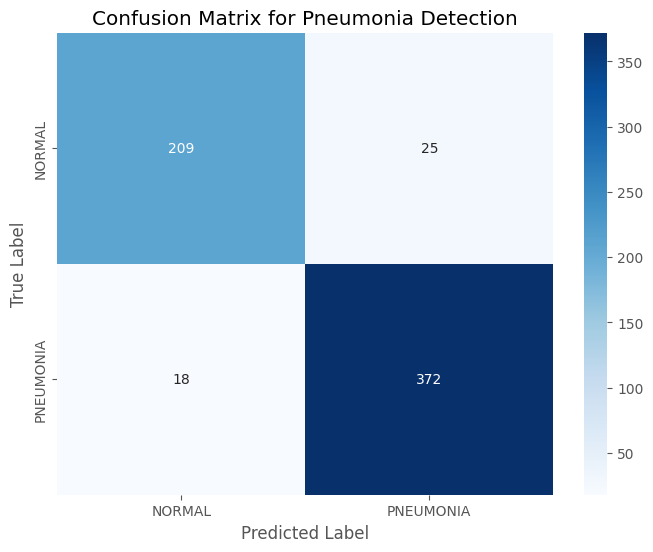

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize the test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the test data
test_generator = test_datagen.flow_from_directory(
    "chest_xray/chest_xray/test",  # Adjust the path as necessary
    batch_size=32,
    target_size=(224,224),
    class_mode='categorical',
    shuffle=False,  # Important to keep the order for evaluation
    seed=42,
    color_mode='rgb'
)

# Get the true labels
true_labels = test_generator.classes

# Make predictions using the ensemble model
predictions = wt_ensemble_model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define class labels (adjust based on your classes)
labels = test_generator.class_indices.keys()  # Extract class names from generator

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Pneumonia Detection')
plt.show()


In [ ]:
## ensemble model--

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19, EfficientNetB0, DenseNet121
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create VGG19 model
def create_vgg19_model(input_shape=(224, 224, 3)):
    base_model = VGG19(include_top=False, input_shape=input_shape, weights='imagenet')
    for layer in base_model.layers[:-5]:
        layer.trainable = False
    for layer in base_model.layers[-5:]:
        layer.trainable = True
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    return Model(inputs=base_model.input, outputs=x)

# Create EfficientNetB0 model
def create_efficientnet_model(input_shape=(224, 224, 3)):
    base_model = EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')
    for layer in base_model.layers[:-15]:
        layer.trainable = False
    for layer in base_model.layers[-15:]:
        layer.trainable = True
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    return Model(inputs=base_model.input, outputs=x)

# Create DenseNet121 model
def create_densenet_model(input_shape=(224, 224, 3)):
    base_model = DenseNet121(include_top=False, input_shape=input_shape, weights='imagenet')
    for layer in base_model.layers[:-10]:
        layer.trainable = False
    for layer in base_model.layers[-10:]:
        layer.trainable = True
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    return Model(inputs=base_model.input, outputs=x)

# Create the ensemble model
def create_ensemble_model(input_shape=(224, 224, 3)):
    input_layer = Input(shape=input_shape)

    vgg_model = create_vgg19_model(input_shape)
    efficientnet_model = create_efficientnet_model(input_shape)
    densenet_model = create_densenet_model(input_shape)

    # Get features from each model
    vgg_features = vgg_model(input_layer)
    efficientnet_features = efficientnet_model(input_layer)
    densenet_features = densenet_model(input_layer)

    # Concatenate features
    concatenated_features = concatenate([vgg_features, efficientnet_features, densenet_features])

    # Fully connected layers after concatenation
    x = BatchNormalization()(concatenated_features)

    # More complex dense layers and adjusted dropout
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)  # Higher dropout to prevent overfitting
    x = BatchNormalization()(x)

    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.4)(x)  # Adjusted dropout
    x = BatchNormalization()(x)

    # Output layer (softmax for binary classification)
    output = Dense(2, activation='softmax')(x)

    # Create the model
    ensemble_model = Model(inputs=input_layer, outputs=output)
    return ensemble_model

# Create the ensemble model
ensemble_model = create_ensemble_model()

# Compile the model with a constant small learning rate
optimizer = Adam(learning_rate=1e-6)  # Constant learning rate
ensemble_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19, EfficientNetB0, DenseNet121
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
import numpy as np

# Function definitions for creating models (VGG19, EfficientNetB0, DenseNet121) here...

# Create the ensemble model
ensemble_model = create_ensemble_model()

# Compile the model
optimizer = Adam(learning_rate=0.00005)
ensemble_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Calculate class weights
y_train = train_generator.classes  # Get the labels from the training generator
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Early stopping and checkpointing
es = EarlyStopping(monitor="val_loss", mode="min", patience=7, restore_best_weights=True, verbose=1)
cp = ModelCheckpoint("model_weights/ensemble_model.keras", monitor="val_loss", save_best_only=True, mode="min", verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train the ensemble model with class weights
history = ensemble_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=50,
    callbacks=[es, cp, lr_scheduler],
    verbose=1,
    class_weight=class_weight_dict  # Pass class weights here
)


Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 793ms/step - accuracy: 0.7156 - loss: 0.6058
Epoch 1: val_loss improved from inf to 0.70342, saving model to model_weights/ensemble_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 213s 954ms/step - accuracy: 0.7159 - loss: 0.6050 - val_accuracy: 0.6875 - val_loss: 0.7034 - learning_rate: 5.0000e-05
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 0.8734 - loss: 0.3026
Epoch 2: val_loss did not improve from 0.70342
163/163 ━━━━━━━━━━━━━━━━━━━━ 143s 812ms/step - accuracy: 0.8735 - loss: 0.3025 - val_accuracy: 0.6875 - val_loss: 1.2261 - learning_rate: 5.0000e-05
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/step - accuracy: 0.9018 - loss: 0.2584
Epoch 3: val_loss did not improve from 0.70342
163/163 ━━━━━━━━━━━━━━━━━━━━ 138s 818ms/step - accuracy: 0.9018 - loss: 0.2583 - val_accuracy: 0.6250 - val_loss: 1.1957 - learning_rate: 5.0000e-05
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 829ms/step - accuracy: 0.9129 - loss: 0.2233
Epoch 4:

In [ ]:
# Evaluate the ensemble model on validation and test sets
ensemble_val_eval = ensemble_model.evaluate(valid_generator)
ensemble_test_eval = ensemble_model.evaluate(test_generator)

# Print the evaluation results
print(f"Validation Loss: {ensemble_val_eval[0]}")
print(f"Validation Accuracy: {ensemble_val_eval[1]}")
print(f"Test Loss: {ensemble_test_eval[0]}")
print(f"Test Accuracy: {ensemble_test_eval[1]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step - accuracy: 0.9375 - loss: 0.1499


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 473ms/step - accuracy: 0.9106 - loss: 0.2680
Validation Loss: 0.14989320933818817
Validation Accuracy: 0.9375
Test Loss: 0.28282034397125244
Test Accuracy: 0.9230769276618958


In [ ]:
# Save the model
ensemble_model.save(filepath="model_weights/ensemble_model_best(92.3).h5", overwrite=True)

In [ ]:
import pandas as pd
# Convert the history.history dictionary to a DataFrame
history_df = pd.DataFrame(history.history)

# Save the DataFrame to a CSV file
history_df.to_csv('model_history_best(91.3).csv', index=False)

In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Assuming you have two classes: "Normal" and "Pneumonia"
# Replace 'your_classes' with the actual class labels used in your dataset
classes = ['Normal', 'Pneumonia']

# Calculate class weights
y_train = train_generator.classes  # Get the labels from the training generator
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Convert to a dictionary
class_weight_dict = dict(enumerate(class_weights))

print("Class Weights: ", class_weight_dict)


Class Weights:  {0: 1.9448173005219984, 1: 0.6730322580645162}


Found 624 images belonging to 2 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step


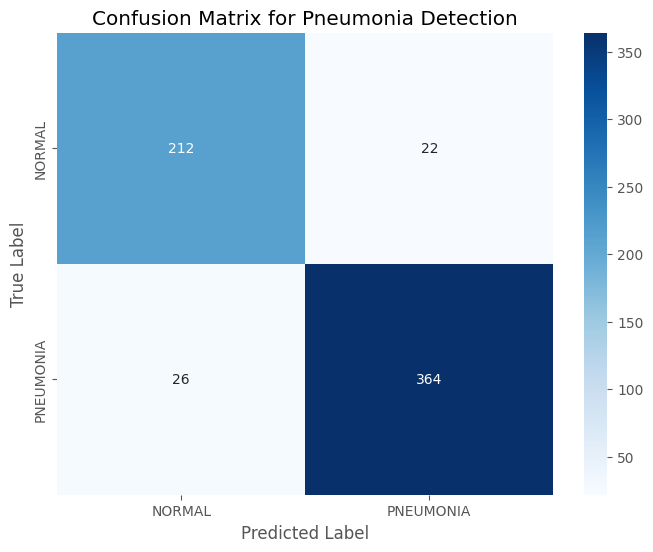

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize the test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the test data
test_generator = test_datagen.flow_from_directory(
    "chest_xray/chest_xray/test",  # Adjust the path as necessary
    batch_size=32,
    target_size=(224,224),
    class_mode='categorical',
    shuffle=False,  # Important to keep the order for evaluation
    seed=42,
    color_mode='rgb'
)

# Get the true labels
true_labels = test_generator.classes

# Make predictions using the ensemble model
predictions = ensemble_model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define class labels (adjust based on your classes)
labels = test_generator.class_indices.keys()  # Extract class names from generator

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Pneumonia Detection')
plt.show()


# Generating HeatMap **Images**

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def preprocess_image(img_path, target_size):
    img = load_img(img_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalize
    return img

def make_gradcam_heatmap(model, img_tensor, last_conv_layer_name, classifier_layer_names):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        loss = predictions[:, 1]  # Targeting class 1 for pneumonia

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = tf.where(tf.math.is_nan(heatmap), tf.zeros_like(heatmap), heatmap)

    return heatmap.numpy()

def create_custom_colormap():
    colors = ['blue', 'green', 'yellow', 'red']
    n_bins = 256  # Increase for smoother color transition
    cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)
    return cmap

def apply_custom_colormap(heatmap, cmap):
    colored_heatmap = cmap(heatmap)
    colored_heatmap = np.uint8(colored_heatmap * 255)
    return colored_heatmap

def enhance_heatmap(heatmap, gamma=0.7, percentile=99):
    # Apply gamma correction
    heatmap = np.power(heatmap, gamma)

    # Normalize to [0, 1] based on the 99th percentile
    heatmap = heatmap / np.percentile(heatmap, percentile)

    # Clip values to [0, 1]
    heatmap = np.clip(heatmap, 0, 1)

    return heatmap

def generate_and_merge_heatmaps(img_path, vgg_model, efficientnet_model, densenet_model, img_size=(224, 224), output_size=(5, 5)):
    img_tensor = preprocess_image(img_path, img_size)

    # Create heatmaps for each model
    vgg_heatmap = make_gradcam_heatmap(vgg_model, img_tensor, 'block5_conv4', ['flatten', 'dense'])
    efficientnet_heatmap = make_gradcam_heatmap(efficientnet_model, img_tensor, 'top_conv', ['flatten', 'dense'])
    densenet_heatmap = make_gradcam_heatmap(densenet_model, img_tensor, 'conv5_block16_concat', ['flatten', 'dense'])

    # Resize heatmaps to match input image size
    vgg_heatmap_resized = cv2.resize(vgg_heatmap, (img_size[0], img_size[1]))
    efficientnet_heatmap_resized = cv2.resize(efficientnet_heatmap, (img_size[0], img_size[1]))
    densenet_heatmap_resized = cv2.resize(densenet_heatmap, (img_size[0], img_size[1]))

    # Merge the heatmaps
    merged_heatmap = (vgg_heatmap_resized + efficientnet_heatmap_resized + densenet_heatmap_resized) / 3.0

    # Enhance the merged heatmap
    enhanced_heatmap = enhance_heatmap(merged_heatmap)

    # Create and apply custom colormap
    custom_cmap = create_custom_colormap()
    colored_heatmap = apply_custom_colormap(enhanced_heatmap, custom_cmap)

    # Load the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, img_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

    # Superimpose the heatmap on the original image
    superimposed_img = cv2.addWeighted(img, 0.6, colored_heatmap[:, :, :3], 0.4, 0)

    # Display the result with the resized output
    plt.figure(figsize=output_size)
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title("Enhanced Multi-color Heatmap")

    # No color bar added
    plt.show()

    return superimposed_img





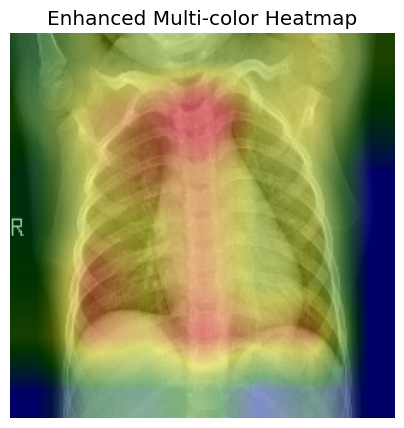

In [ ]:
# Example usage:
img_path = 'chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0321-0001.jpeg'
final_heatmap_image = generate_and_merge_heatmaps(
    img_path,
    create_vgg19_model(),
    create_efficientnet_model(),
    create_densenet_model()
)

**Test data of various sizes**

In [ ]:
## 93.108

In [ ]:
!pip install --upgrade tensorflow

from tensorflow.keras.models import load_model

# Reload the saved models
vgg19_model = load_model('model_weights/vgg19_model_04.h5')
efficientnet_model = load_model('model_weights/efficientnet_model_05.h5')
densenet_model = load_model('model_weights/densenet121_model_02.h5')
ensemble_model = wt_ensemble_model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 965.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 201.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 101.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 23.2 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorflow

In [ ]:
# After loading the model
vgg19_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
efficientnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
densenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
ensemble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import from tensorflow.keras instead of just keras

# Set the image size and other parameters
img_size = 224
batch_size = 32

# Create an instance of ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the full test data
full_test_generator = test_datagen.flow_from_directory(
    'chest_xray/chest_xray/test',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

# Calculate total number of test samples
total_samples = full_test_generator.samples  # Total samples in the test directory

# Define percentages
percentages = [0.25, 0.5, 0.75]  # 20%, 50%, and 100%

# Evaluate the models for different sample sizes
for percentage in percentages:
    # Calculate number of samples for the given percentage
    num_samples = int(total_samples * percentage)
    steps = num_samples // batch_size  # Calculate steps for evaluation

    # Evaluate the ensemble model on the current percentage of test data
    vgg19_test_eval = vgg19_model.evaluate(full_test_generator, steps=steps)
    efficientnet_test_eval = efficientnet_model.evaluate(full_test_generator, steps=steps)
    densenet_test_eval = densenet_model.evaluate(full_test_generator, steps=steps)
    ensemble_test_eval = ensemble_model.evaluate(full_test_generator, steps=steps)
    print(f"Ensemble Model Performance on {int(percentage*100)}% Test Data: {vgg19_test_eval}")
    print(f"Ensemble Model Performance on {int(percentage*100)}% Test Data: {efficientnet_test_eval}")
    print(f"Ensemble Model Performance on {int(percentage*100)}% Test Data: {densenet_test_eval}")
    print(f"Ensemble Model Performance on {int(percentage*100)}% Test Data: {ensemble_test_eval}")

In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import from tensorflow.keras instead of just keras

# Set the image size and other parameters
img_size = 224
batch_size = 32

# Create an instance of ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the full test data
full_test_generator = test_datagen.flow_from_directory(
    'chest_xray/chest_xray/test',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

# Calculate total number of test samples
total_samples = full_test_generator.samples  # Total samples in the test directory

# Define percentages
percentages = [0.25, 0.5, 0.75]  # 20%, 50%, and 100%

# Evaluate the models for different sample sizes
for percentage in percentages:
    # Calculate number of samples for the given percentage
    num_samples = int(total_samples * percentage)
    steps = num_samples // batch_size  # Calculate steps for evaluation

    # Evaluate the ensemble model on the current percentage of test data
    vgg19_test_eval = vgg19_model.evaluate(full_test_generator, steps=steps)
    efficientnet_test_eval = efficientnet_model.evaluate(full_test_generator, steps=steps)
    densenet_test_eval = densenet_model.evaluate(full_test_generator, steps=steps)
    ensemble_test_eval = ensemble_model.evaluate(full_test_generator, steps=steps)
    print(f"Ensemble Model Performance on {int(percentage*100)}% Test Data: {vgg19_test_eval}")
    print(f"Ensemble Model Performance on {int(percentage*100)}% Test Data: {efficientnet_test_eval}")
    print(f"Ensemble Model Performance on {int(percentage*100)}% Test Data: {densenet_test_eval}")
    print(f"Ensemble Model Performance on {int(percentage*100)}% Test Data: {ensemble_test_eval}")

Found 624 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 417ms/step - accuracy: 0.9500 - loss: 0.1592
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 406ms/step - accuracy: 0.9219 - loss: 0.1972
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 513ms/step - accuracy: 0.8656 - loss: 0.3564
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 561ms/step - accuracy: 0.9729 - loss: 0.1043
Ensemble Model Performance on 25% Test Data: [0.21562129259109497, 0.921875]
Ensemble Model Performance on 25% Test Data: [0.36877673864364624, 0.8671875]
Ensemble Model Performance on 25% Test Data: [0.38635653257369995, 0.8359375]
Ensemble Model Performance on 25% Test Data: [0.13419879972934723, 0.9609375]
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 666ms/step - accuracy: 0.9155 - loss: 0.2588
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 440ms/step - accuracy: 0.8894 - loss: 0.3359
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 407ms/step - accuracy: 0.8285 - loss: 0.4117
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 632ms/step - accuracy: 0.9344 - loss: 0.1926
Ensemble Model Performance on 50% Test Data: [0.3258742690086365, 0.8819444179534912]
Ensemble Model Pe

In [ ]:
from tensorflow.keras.models import load_model

# Reload the saved models
vgg19_model = load_model('model_weights/vgg19_model_04.h5')
efficientnet_model = load_model('model_weights/efficientnet_model_05.h5')
densenet_model = load_model('model_weights/densenet121_model_02.h5')
ensemble_model = load_model('model_weights/ensemble_model_best(92.3).h5')

In [ ]:
# After loading the model
vgg19_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
efficientnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
densenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
ensemble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
